# Машинное обучение, ФКН ВШЭ

## Практическое задание 2. Exploratory Data Analysis и линейная регрессия

### Общая информация
Дата выдачи: 02.02.2024

Мягкий дедлайн: 23:59MSK 26.02.2024

Жесткий дедлайн: 23:59MSK 09.03.2024

### О задании
В этом задании мы попытаемся научиться анализировать данные и выделять из них полезные признаки. Мы также научимся пользоваться `seaborn` и `sklearn`, а заодно привыкнем к основным понятиям машинного обучения.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Проверяющий имеет право снизить оценку за неэффективную реализацию или неопрятные графики.

**Обратите внимание**, что в каждом разделе домашнего задания есть оцениваниемые задачи и есть вопросы. Вопросы дополняют задачи и направлены на то, чтобы проинтерпретировать или обосновать происходящее. Код без интерпретации не имеет смысла, поэтому отвечать на вопросы обязательно — за отсутствие ответов мы будем снижать баллы за задачи. Если вы ответите на вопросы, но не напишете корректный код к соответствующим оцениваемым задачам, то баллы за такое выставлены не будут.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

### Формат сдачи
Задания сдаются через систему Anytask. Инвайт можно найти на странице курса. Присылать необходимо ноутбук с выполненным заданием. Сам ноутбук называйте в формате homework-practice-02-linregr-Username.ipynb, где Username — ваша фамилия.

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

Оценка: xx.

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from math import radians, cos, sin, asin, sqrt
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge, Lasso
from collections import Counter

В этом ноутбуке используется библиотека `folium` для визуализации карт. Она работает в google colab!

In [2]:
!pip install folium

In [3]:
import folium

m = folium.Map(location=(55.7522200, 37.6155600), zoom_start=10)

m

Если вы всё сделали правильно, то выше должна открыться карта Москвы.

In [4]:
%matplotlib inline

sns.set(style="darkgrid")

np.random.seed(0)

## Часть 0. Подготовка (1 балл)

**Задание 1 (1 балл)**. Мы будем работать с данными из соревнования [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview), в котором нужно было предсказать длительность поездки на такси. Скачайте обучающую выборку из этого соревнования и загрузите ее:

In [5]:
from google.colab import drive
drive.mount('/content/drive')

!gdown --id 1zsH3FXewEKJ-fvNDPhqW7JQW-zN2BDQu -O /content/train-2.csv


Mounted at /content/drive
/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1zsH3FXewEKJ-fvNDPhqW7JQW-zN2BDQu
From (redirected): https://drive.google.com/uc?id=1zsH3FXewEKJ-fvNDPhqW7JQW-zN2BDQu&confirm=t&uuid=22d6eafb-6398-4353-8b07-f8b04dcd195d
To: /content/train-2.csv
100% 201M/201M [00:03<00:00, 65.8MB/s]


Обратите внимание на колонки `pickup_datetime` и `dropoff_datetime`. `dropoff_datetime` был добавлена организаторами только в обучающую выборку, то есть использовать эту колонку нельзя, давайте удалим ее. В `pickup_datetime` записаны дата и время начала поездки. Чтобы с ней было удобно работать, давайте преобразуем даты в `datetime`-объекты

In [6]:
df = pd.read_csv('/content/train-2.csv')

df.drop('dropoff_datetime', axis=1, inplace=True)
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

df.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,435


В колонке `trip_duration` записано целевое значение, которое мы хотим предсказывать. Давайте посмотрим на распределение таргета в обучающей выборке. Для этого нарисуйте его гистограмму:

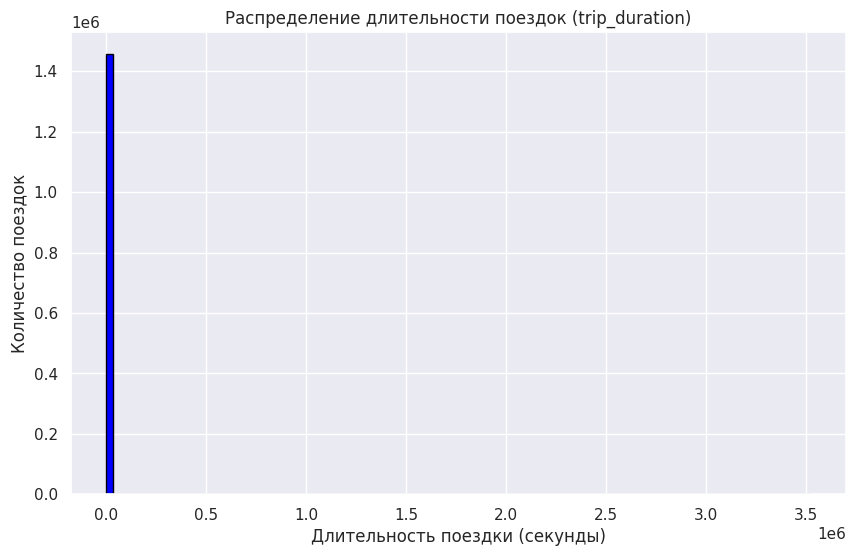

In [7]:
plt.figure(figsize=(10, 6))
plt.hist(df['trip_duration'], bins=100, color='blue', edgecolor='black')
plt.title('Распределение длительности поездок (trip_duration)')
plt.xlabel('Длительность поездки (секунды)')
plt.ylabel('Количество поездок')
plt.show()


**Вопрос**: Что можно сказать о целевой переменной по гистограмме её значений?

In [9]:
print("Sec:", np.exp(5), np.exp(8))
print("Min:", np.exp(5) // 60, np.exp(8) // 60)

Sec: 148.4131591025766 2980.9579870417283
Min: 2.0 49.0


In [10]:
print(f"Longest duration (hours) = {df['trip_duration'].max() // 3600}")

Longest duration (hours) = 979


В основмном все ок, но есть странные выбросы по типу поездки продолжительностью 900ч

В соревновании в качестве метрики качества использовалось RMSLE:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$

**Вопрос**: Как вы думаете, почему авторы соревнования выбрали именно RMSLE, а не RMSE?

1. Возможно такая метрика менее чувствительна к таким большим выбросам
2. Параметр меньше по значеню (логарифмический) = легче обучаться
3. => Разброс меньше и следовательно ошибка меньше

На семинаре мы рассматривали несколько моделей линейной регрессии в `sklearn`, но каждая из них оптимизировала среднеквадратичную ошибку (MSE), а не RMSLE. Давайте проделаем следующий трюк: будем предсказывать не целевую переменную, а ее *логарифм*. Обозначим $\hat{y}_i = \log{(y_i + 1)}$ — модифицированный таргет, а $\hat{a}(x_i)$ — предсказание модели, которая обучалась на $\hat{y}_i$, то есть логарифм таргета. Чтобы предсказать исходное значение, мы можем просто взять экспоненту от нашего предсказания: $a(x_i) = \exp(\hat{a}(x_i)) - 1$.

**Вопрос**: Покажите, что оптимизация RMSLE для модели $a$ эквивалентна оптимизации MSE для модели $\hat{a}$.

**Доказательство**:


$\hat{y}_i = \log{(y_i + 1)} <=> y_i = \exp{\hat{y_i}} - 1$

$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2} = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(\exp{\hat{y_i}} - 1 + 1)} - \log{(\exp(\hat{a}(x_i)) - 1 + 1)}\big)^2} =  \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(\exp{\hat{y_i}})} - \log{(\exp(\hat{a}(x_i)))}\big)^2} =  \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\hat{y_i} - \hat{a}(x_i)\big)^2} = \text{RMSE}(X, \hat{y}, \hat{a}) = \sqrt{\text{MSE}(X, \hat{y}, \hat{a})}$$

Итак, мы смогли свести задачу оптимизации RMSLE к задаче оптимизации MSE, которую мы умеем решать! Кроме того, у логарифмирования таргета есть еще одно полезное свойство. Чтобы его увидеть, добавьте к нашей выборке колонку `log_trip_duration` (воспользуйтесь `np.log1p`) и нарисуйте гистограмму модифицированного таргета по обучающей выборке. Удалите колонку со старым таргетом.

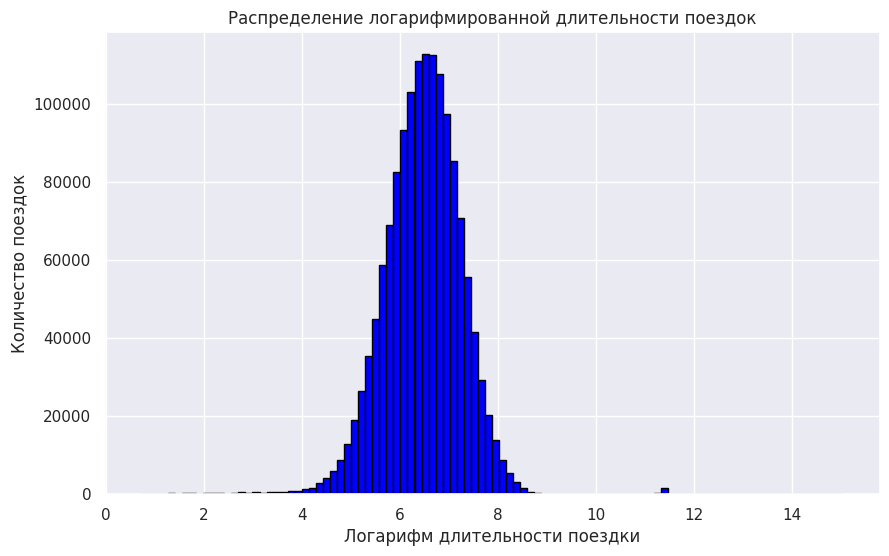

In [11]:
df['log_trip_duration'] = np.log1p(df['trip_duration'])

df.drop('trip_duration', axis=1, inplace=True)

plt.figure(figsize=(10, 6))
plt.hist(df['log_trip_duration'], bins=100, color='blue', edgecolor='black')
plt.title('Распределение логарифмированной длительности поездок')
plt.xlabel('Логарифм длительности поездки')
plt.ylabel('Количество поездок')
plt.show()


Чтобы иметь некоторую точку отсчета, давайте посчитаем значение метрики при наилучшем константном предсказании:

In [12]:
def rmsle(log1p_y_true, log1p_y_pred):
    return np.sqrt(np.mean((log1p_y_true - log1p_y_pred) ** 2))


log1p_y_true = df['log_trip_duration']
log1p_y_pred = np.full(log1p_y_true.shape, log1p_y_true.mean())

rmsle_best_const = rmsle(log1p_y_true, log1p_y_pred)
print(rmsle_best_const)

assert np.allclose(rmsle_best_const, 0.79575, 1e-4)

0.7957592365411509


## Часть 1. Изучаем `pickup_datetime` (2 балла)

**Задание 2 (0.25 баллов)**. Для начала давайте посмотрим, сколько всего было поездок в каждый из дней. Постройте график зависимости количества поездок от дня в году (например, можно воспользоваться `sns.countplot`):

In [13]:
df['day_of_year'] = df['pickup_datetime'].dt.dayofyear
df['day_of_week'] = df['pickup_datetime'].dt.dayofweek
df['hour_of_day'] = df['pickup_datetime'].dt.hour

<ipython-input-14-9ba6ebd986d6>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_xticklabels(labels)


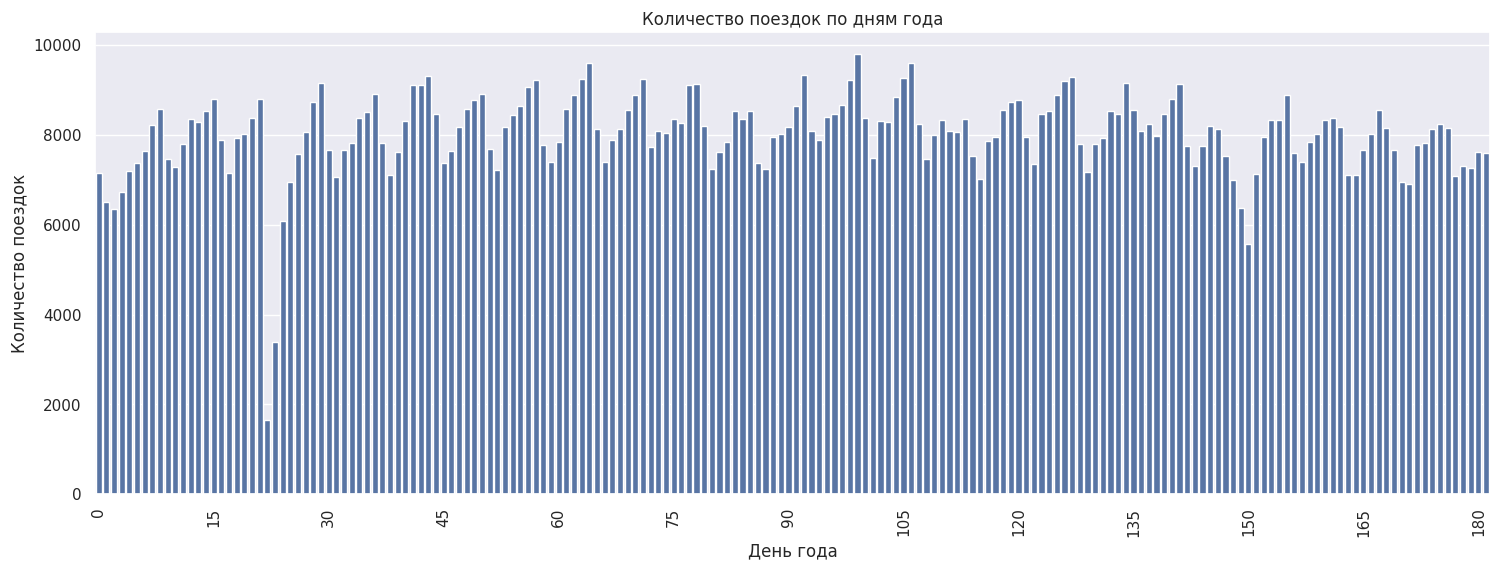

In [14]:
plt.figure(figsize=(18, 6))
sns.countplot(x='day_of_year', data=df)
plt.title('Количество поездок по дням года')
plt.xlabel('День года')
plt.ylabel('Количество поездок')

ticks = plt.gca().get_xticks()
labels = [int(item) if (i % 15 == 0) else '' for i, item in enumerate(ticks)]
plt.gca().set_xticklabels(labels)

plt.xticks(rotation=90)
plt.show()



**Вопрос**: Вы, вероятно, заметили, что на графике есть 2 периода с аномально маленькими количествами поездок. Вычислите, в какие даты происходили эти скачки вниз и найдите информацию о том, что происходило в эти дни в Нью-Йорке.

Нарисуйте графики зависимости количества поездок от дня недели и от часов в сутках (воспользуйтесь `sns.relplot`):

датасет за 2016 год, была снежная буря в США 26 января в это время

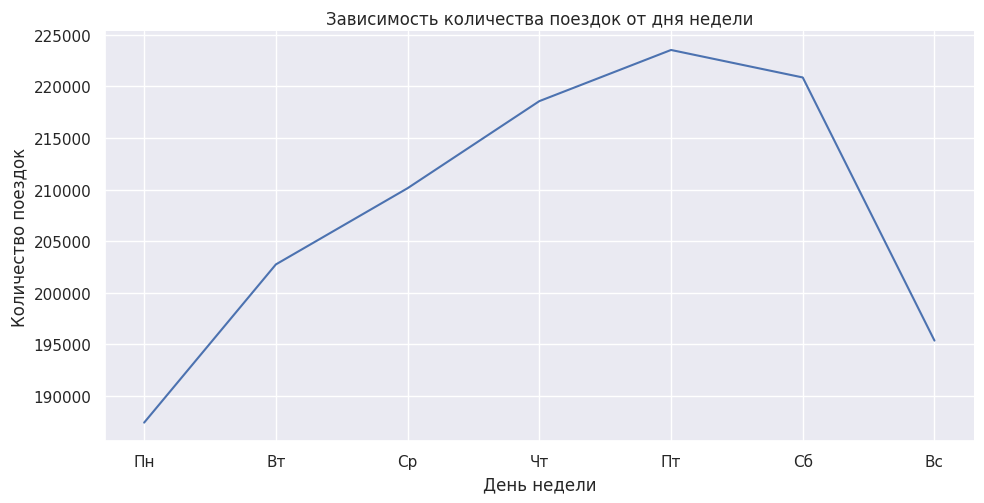

In [15]:
sns.relplot(x='day_of_week', y='day_of_year', kind='line', data=df.groupby('day_of_week')['day_of_year'].count().reset_index(), aspect=2)
plt.title('Зависимость количества поездок от дня недели')
plt.xlabel('День недели')
plt.ylabel('Количество поездок')
plt.xticks(range(7), ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
plt.show()


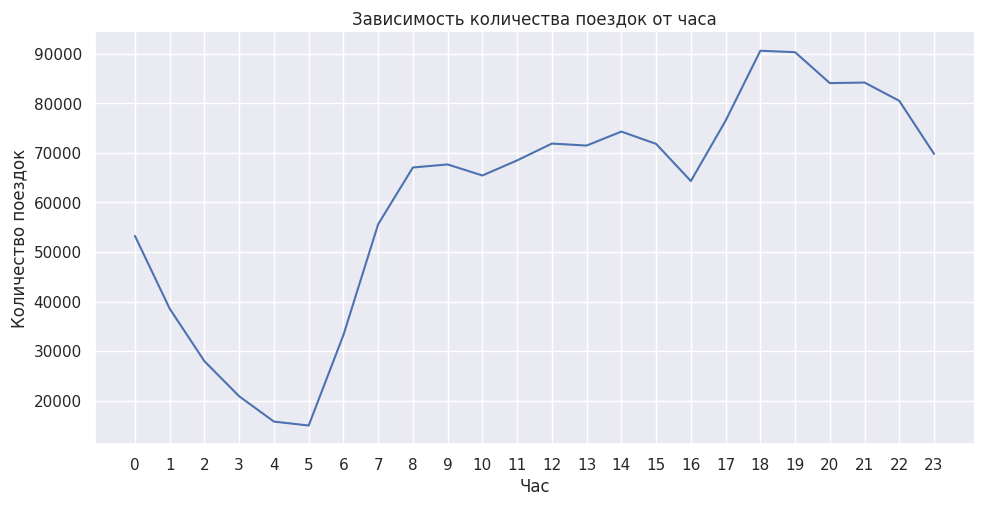

In [16]:
sns.relplot(x='hour_of_day', y='day_of_year', kind='line', data=df.groupby('hour_of_day')['day_of_year'].count().reset_index(), aspect=2)
plt.title('Зависимость количества поездок от часа')
plt.xlabel('Час')
plt.ylabel('Количество поездок')
plt.xticks(range(24))
plt.show()


**Задание 3 (0.5 баллов)**. Нарисуйте на одном графике зависимости количества поездок от часа в сутках для разных месяцев (разные кривые, соответствующие разным месяцам, окрашивайте в разные цвета, воспользуйтесь `hue` в `sns.relplot`). Аналогично нарисуйте зависимости количества поездок от часа в сутках для разных дней недели.

In [17]:
df['month'] = df['pickup_datetime'].dt.month

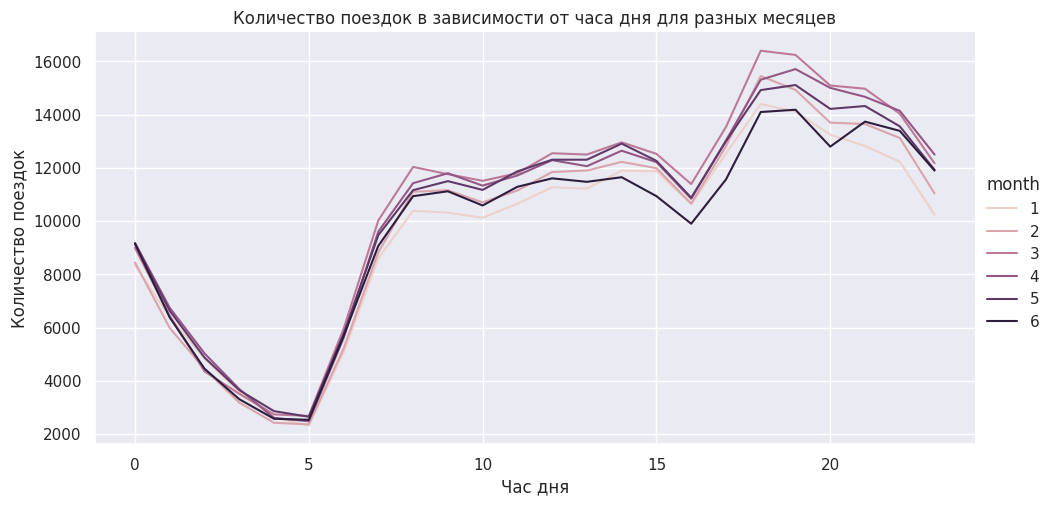

In [18]:
sns.relplot(x='hour_of_day', y='count', hue='month', kind='line', data=df.groupby(['month', 'hour_of_day']).size().reset_index(name='count'), aspect=2)
plt.title('Количество поездок в зависимости от часа дня для разных месяцев')
plt.xlabel('Час дня')
plt.ylabel('Количество поездок')
plt.show()


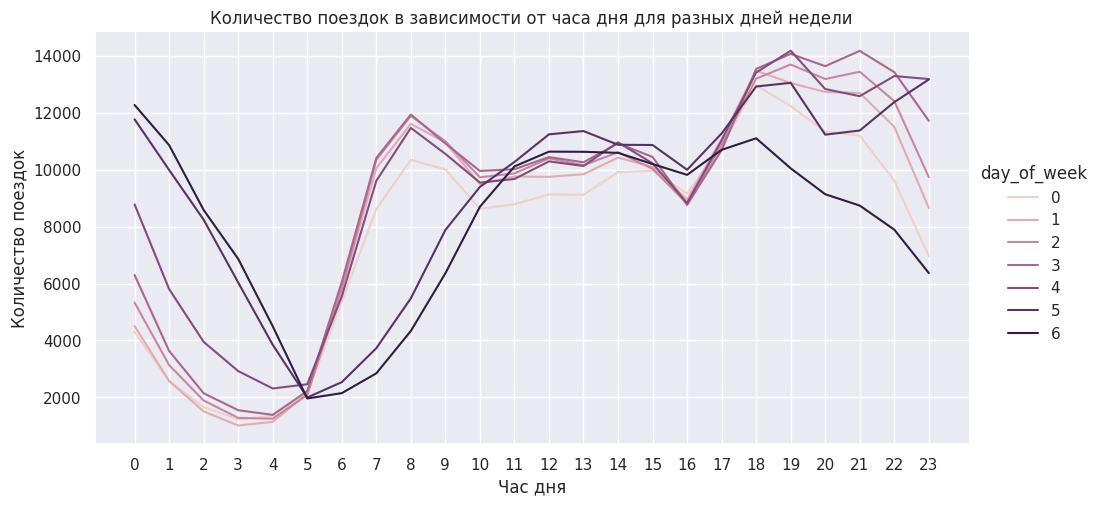

In [19]:
sns.relplot(x='hour_of_day', y='count', hue='day_of_week', kind='line', data=df.groupby(['day_of_week', 'hour_of_day']).size().reset_index(name='count'), aspect=2)
plt.title('Количество поездок в зависимости от часа дня для разных дней недели')
plt.xlabel('Час дня')
plt.ylabel('Количество поездок')
plt.xticks(range(0, 24))
plt.show()


В промежуток с 2 часов ночи до 6 утра наблюдается значительный спад спроса, этот спад является минимальным за весь день. Пик приходится на 18 часов, когда все топают с работы

**Вопрос**: Какие выводы можно сделать, основываясь на графиках выше? Выделяются ли какие-нибудь дни недели? Месяца? Время суток? С чем это связано?

**Задание 4 (0.5 баллов)**. Разбейте выборку на обучающую и тестовую в отношении 7:3 (используйте `train_test_split` из `sklearn`). По обучающей выборке нарисуйте график зависимости среднего логарифма времени поездки от дня недели. Затем сделайте то же самое, но для часа в сутках и дня в году.

In [20]:


train, test = train_test_split(df, test_size=0.3, random_state=42)

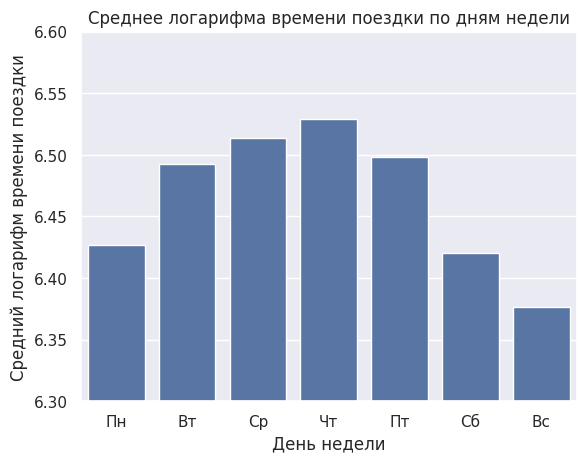

In [21]:
sns.barplot(x='day_of_week', y='log_trip_duration', data=train.groupby('day_of_week')['log_trip_duration'].mean().reset_index())
plt.title('Среднее логарифма времени поездки по дням недели')
plt.xlabel('День недели')
plt.ylabel('Средний логарифм времени поездки')
plt.xticks(range(0, 7), ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'])
plt.ylim(6.3, 6.6)
plt.show()

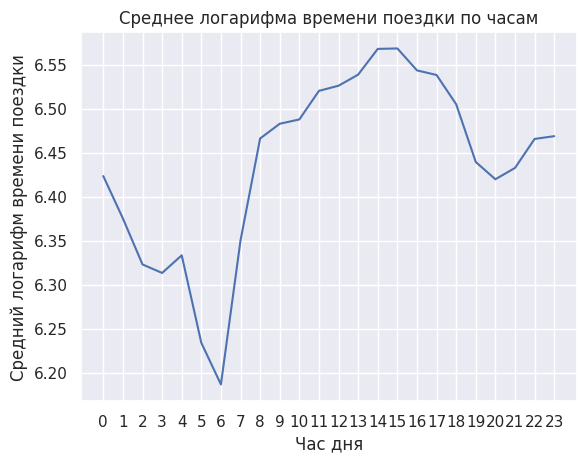

In [22]:
sns.lineplot(x='hour_of_day', y='log_trip_duration', data=train.groupby('hour_of_day')['log_trip_duration'].mean().reset_index())
plt.title('Среднее логарифма времени поездки по часам')
plt.xlabel('Час дня')
plt.ylabel('Средний логарифм времени поездки')
plt.xticks(range(0, 24))
plt.show()


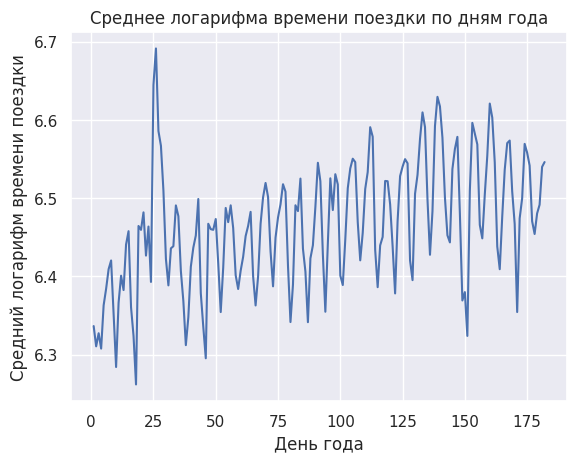

In [23]:
sns.lineplot(x='day_of_year', y='log_trip_duration', data=train.groupby('day_of_year')['log_trip_duration'].mean().reset_index())
plt.title('Среднее логарифма времени поездки по дням года')
plt.xlabel('День года')
plt.ylabel('Средний логарифм времени поездки')
plt.show()


**Вопрос**: Похожи ли графики зависимости таргета от дня недели и от часа в сутках на аналогичные графики для количества поездок? Почему? Что происходит со средним таргетом в те два аномальных периода, что мы видели выше? Почему так происходит? Наблюдаете ли вы какой-нибудь тренд на графике зависимости `log_trip_duration` от номера дня в году?

График, показывающий связь между целевым показателем и временем суток, сильно напоминает аналогичный график для количества поездок, в отличие от связи целевого показателя с днями недели. Это, вероятно, объясняется увеличением спроса в определённые временные промежутки, такие как начало и конец рабочего дня или учебы, что приводит к увеличению загруженности дорог и, как следствие, к увеличению времени в пути.

Во время первого аномального периода было замечено значительное увеличение среднего значения целевого показателя, что, по всей видимости, было вызвано экстремально сложными условиями передвижения из-за снежной бури. В течение второго периода, при снижении спроса, была зафиксирована уменьшенная продолжительность поездок, что может быть связано с остановкой работы аэропорта, в результате чего произошел сбой в работе GPS, и перемещения стали менее удалёнными.

Добавьте следующие признаки на основе `pickup_datetime`:
1. День недели
2. Месяц
3. Час
4. Является ли период аномальным (два бинарных признака, соответствующие двум аномальным периодам)
5. Номер дня в году

In [24]:
df["weekday"] = df["pickup_datetime"].dt.weekday
df["month"] = df["pickup_datetime"].dt.month
df["hour"] = df["pickup_datetime"].dt.hour

anomaly_1_dates = [datetime.date(2016, 1, 23), datetime.date(2016, 1, 24), datetime.date(2016, 1, 25)]
anomaly_2_dates = [datetime.date(2016, 5, 29), datetime.date(2016, 5, 30)]

df["anomaly_1"] = df["pickup_datetime"].dt.date.isin(anomaly_1_dates).astype(int)
df["anomaly_2"] = df["pickup_datetime"].dt.date.isin(anomaly_2_dates).astype(int)

start_date = pd.to_datetime('2016-01-01')
df["day_number"] = (df["pickup_datetime"].dt.date - start_date.date()).dt.days + 1

train, test = train_test_split(df, test_size=0.3, random_state=42)

count_train_anomaly_1 = train["anomaly_1"].sum()
count_train_anomaly_2 = train["anomaly_2"].sum()
count_test_anomaly_1 = test["anomaly_1"].sum()
count_test_anomaly_2 = test["anomaly_2"].sum()

print(f"Count train anomalies_1: {count_train_anomaly_1}")
print(f"Count train anomalies_2: {count_train_anomaly_2}")
print(f"Count test anomalies_1: {count_test_anomaly_1}")
print(f"Count test anomalies_2: {count_test_anomaly_2}")


Count train anomalies_1: 7828
Count train anomalies_2: 8402
Count test anomalies_1: 3287
Count test anomalies_2: 3540


Итак, мы уже создали некоторое количество признаков.

**Вопрос**: Какие из признаков _стоит рассматривать в этой задаче_   как категориальные, а какие - как численные? Почему?

**Лишние**

*   id
*   pickup_datetime

**Категориальные**

*   vendor_id
*   store_and_fwd_flag
*   weekday
*   month
*   anomaly_1
*   anomaly_2


**Числовые**

*   passenger_count
*   pickup_longtitude
*   pickup_latitude
*   dropoff_longtitude
*   dropoff_latitude
*   hour
*   day_number

**Задание 5 (0.75 баллов)**. Обучите `Ridge`-регрессию с параметрами по умолчанию, закодировав все категориальные признаки с помощью `OneHotEncoder`. Численные признаки отмасштабируйте с помощью `StandardScaler`. Используйте только признаки, которые мы выделили в этой части задания.

In [25]:
categorical_features = ['weekday', 'month', 'anomaly_1', 'anomaly_2']
numerical_features = [ 'hour', 'day_number']


In [26]:
categorical_pipeline = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numerical_pipeline = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features),
        ('cat', categorical_pipeline, categorical_features)
    ]
)

ridge_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', Ridge())
])

X = train[categorical_features + numerical_features]
y = train['log_trip_duration']

ridge_pipeline.fit(X, y)

X_test = test[categorical_features + numerical_features]
y_test = test['log_trip_duration']

y_pred = ridge_pipeline.predict(X_test)


In [27]:
print("Test MSE:", mean_squared_error(y_test, y_pred))
print("Test RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("Test RMSLE:", mean_squared_log_error(y_test, y_pred, squared=False))


Test MSE: 0.6267957657189742
Test RMSE: 0.7917043423646066
Test RMSLE: 0.11260787742490162


## Часть 2. Изучаем координаты (3 балла)
Мы уже очень хорошо изучили данные о времени начала поездки, давайте теперь посмотрим на информацию о координатах начала и конца поездки. Мы подготовили для вас функцию, которая на карте рисует точки начала или конца поездки. Примеры ее вызова вы найдете ниже. Обратите внимание, что в эту функцию мы передаем лишь небольшой кусочек данных, посколько иначе функция будет работать очень долго

In [28]:
def show_circles_on_map(data, latitude_column, longitude_column, color):
    """
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.

    data: DataFrame that contains columns latitude_column and longitude_column
    latitude_column: string, the name of column for latitude coordinates
    longitude_column: string, the name of column for longitude coordinates
    color: string, the color of circles to be drawn
    """

    location = (data[latitude_column].mean(), data[longitude_column].mean())
    m = folium.Map(location=location)

    for _, row in data.iterrows():
        folium.Circle(
            radius=100,
            location=(row[latitude_column], row[longitude_column]),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

In [29]:
show_circles_on_map(df.sample(1000), "pickup_latitude", "pickup_longitude", "blue")

In [30]:
show_circles_on_map(df.sample(1000), "dropoff_latitude", "dropoff_longitude", "blue")

**Вопрос**: Какие пункты (или скопления точек, в количестве 2-3), по вашему мнению, выделяются на карте от основной массы и могут быть полезны для нашей задачи? Почему вы их выбрали? В чём особенность этих скоплений точек для нашей задачи?

**Задание 6 (0.75 балл)**. Как мы все прекрасно помним, $t = s / v_{\text{ср}}$, поэтому очевидно, что самым сильным признаком будет расстояние, которое необходимо проехать. Мы не можем посчитать точное расстояние, которое необходимо преодолеть такси, но мы можем его оценить, посчитав кратчайшее расстояние между точками начала и конца поездки. Чтобы корректно посчитать расстояние между двумя точками на Земле, можно использовать функцию `haversine`. Также можно воспользоваться кодом с первого семинара. Посчитайте кратчайшее расстояние для объектов и запишите его в колонку `haversine`:

In [31]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # в км
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h


In [32]:
train['haversine'] = haversine_array(train['pickup_latitude'], train['pickup_longitude'],
                                     train['dropoff_latitude'], train['dropoff_longitude'])




Так как мы предсказываем логарифм времени поездки и хотим, чтобы наши признаки были линейно зависимы с этой целевой переменной, нам нужно логарифмировать расстояние: $\log t = \log s - \log{v_{\text{ср}}}$. Запишите логарифм `haversine` в отдельную колонку `log_haversine`:

In [33]:
train['log_haversine'] = np.log1p(train['haversine'])

Убедимся, что логарифм расстояния лучше коррелирует с нашим таргетом, чем просто расстояние:

In [34]:
log_haversine_corr = train['log_haversine'].corr(train['log_trip_duration'])
haversine_corr = train['haversine'].corr(train['log_trip_duration'])

print(f"Корреляция между log_haversine и log_trip_duration: {log_haversine_corr}")
print(f"Корреляция между haversine и log_trip_duration: {haversine_corr}")

assert train['log_haversine'].corr(train['log_trip_duration']) > train['haversine'].corr(train['log_trip_duration'])


Корреляция между log_haversine и log_trip_duration: 0.7499594955685644
Корреляция между haversine и log_trip_duration: 0.5654059873890238


**Задание 7 (0.75 балла)**. Давайте изучим среднюю скорость движения такси. Посчитайте среднюю скорость для каждого объекта обучающей выборки, разделив `haversine` на `trip_duration`, и нарисуйте гистограмму ее распределения

In [35]:
train['average_speed_kmh'] = train['haversine'] / (train['log_trip_duration'] / 3600)

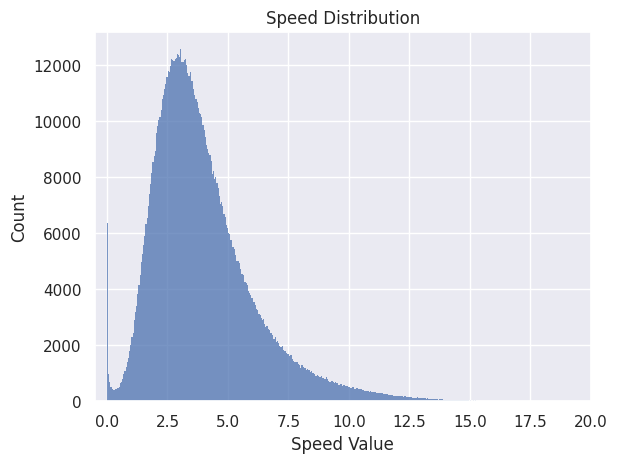

In [36]:
mean_speed = train['haversine'] / (np.exp(train['log_trip_duration']) - 1) * 1000

sns.histplot(
    mean_speed,
)

plt.xlabel("Speed Value")
plt.ylabel("Count")
plt.title("Speed Distribution")

plt.xlim(-0.5, 20)
plt.show()


Как можно видеть по гистограмме, для некоторых объектов у нас получились очень больше значения скоростей. Нарисуйте гистограмму по объектам, для которых значение скорости получилось разумным (например, можно не включать рассмотрение объекты, где скорость больше некоторой квантили):

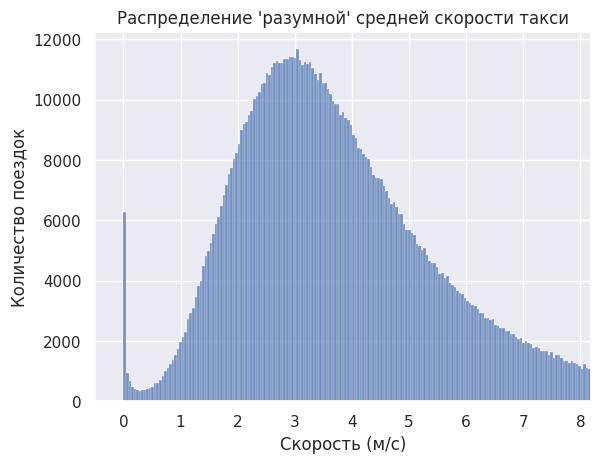

In [37]:
speed_quantile_95 = mean_speed.quantile(0.95)

filtered_speed = mean_speed[mean_speed < speed_quantile_95]

sns.histplot(filtered_speed)
plt.xlabel("Скорость (м/с)")
plt.ylabel("Количество поездок")
plt.title("Распределение 'разумной' средней скорости такси")
plt.xlim(-0.5, speed_quantile_95)
plt.show()


Для каждой пары (день недели, час суток) посчитайте медиану скоростей. Нарисуйте с помощью `sns.heatmap` график, где по осям будут дни недели и часы, а в качестве значения функции - медиана скорости

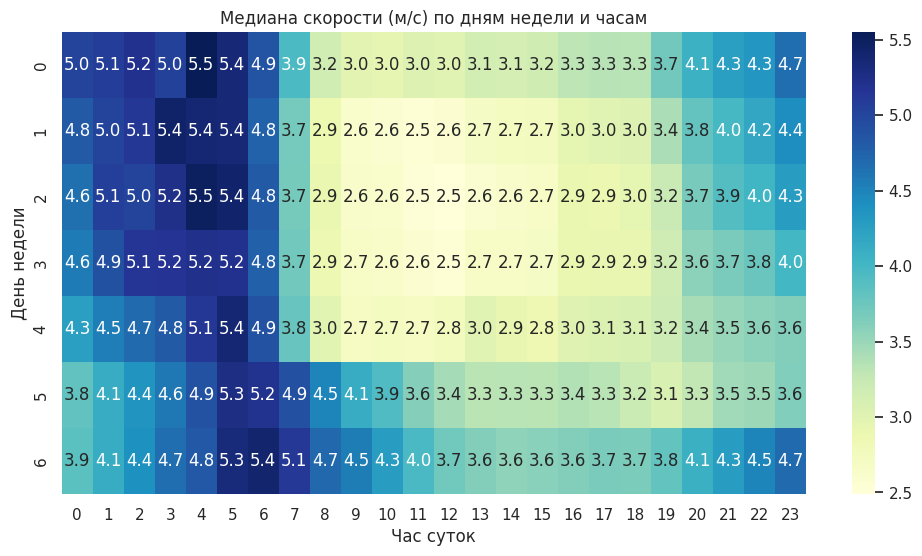

In [38]:
train['filtered_speed'] = filtered_speed

median_speed_weekday_hour = train.groupby(['weekday', 'hour'])['filtered_speed'].median().unstack()

plt.figure(figsize=(12, 6))
sns.heatmap(median_speed_weekday_hour, cmap="YlGnBu", annot=True, fmt=".1f")
plt.title('Медиана скорости (м/с) по дням недели и часам')
plt.xlabel('Час суток')
plt.ylabel('День недели')
plt.show()


Не забудьте удалить колонку со значением скорости из данных!

**Вопрос**: Почему значение скорости нельзя использовать во время обучения?

In [39]:
train.drop(columns=['mean_speed', 'haversine'], inplace=True, errors='ignore')

**Вопрос**: Посмотрите внимательно на график и скажите, в какие моменты времени скорость минимальна; максимальна.

Создайте признаки "поездка совершается в период пробок" и "поездка совершается в период свободных дорог" (естественно, они не должен зависеть от скорости!):

In [40]:
train["rush_hour"] = ((train["hour"] > 7) & (train["hour"] < 10)) | ((train["hour"] > 17) & (train["hour"] < 22))
train["free_from_traffic"] = ((train["hour"] > 1) & (train["hour"] < 7)) | ((train["hour"] > 12) & (train["hour"] < 15))

**Задание 8 (0.25 балла)**. Для каждого из замеченных вами выше 2-3 пунктов добавьте в выборку по два признака:
- началась ли поездка в этом пункте
- закончилась ли поездка в этом пункте

Как вы думаете, почему эти признаки могут быть полезны?

In [41]:
def is_in_point(start_lat, start_lon, end_lat, end_lon, point_lat, point_lon, radius=0.01):
    start_in_point = np.sqrt((start_lat - point_lat)**2 + (start_lon - point_lon)**2) < radius
    end_in_point = np.sqrt((end_lat - point_lat)**2 + (end_lon - point_lon)**2) < radius
    return start_in_point, end_in_point

train['start_in_A'], train['end_in_A'] = zip(*train.apply(lambda row: is_in_point(row['pickup_latitude'],
                                                                                  row['pickup_longitude'],
                                                                                  row['dropoff_latitude'],
                                                                                  row['dropoff_longitude'],
                                                                                  40.748817, -73.985428), axis=1))

train['start_in_B'], train['end_in_B'] = zip(*train.apply(lambda row: is_in_point(row['pickup_latitude'],
                                                                                  row['pickup_longitude'],
                                                                                  row['dropoff_latitude'],
                                                                                  row['dropoff_longitude'],
                                                                                  40.712776, -74.005974), axis=1))


Для каждого из созданных признаков нарисуйте "ящик с усами" (`sns.boxplot`) распределения логарифма времени поездки

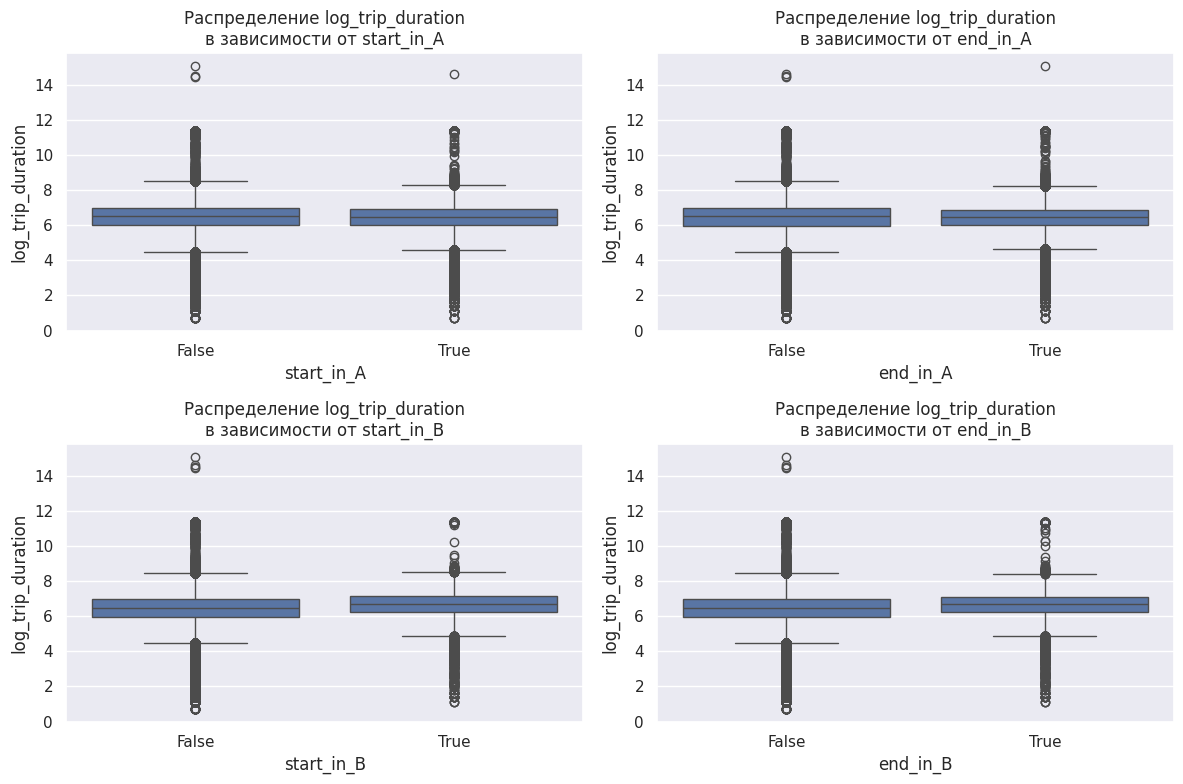

In [42]:
features = ['start_in_A', 'end_in_A', 'start_in_B', 'end_in_B']

plt.figure(figsize=(12, 8))

for i, feature in enumerate(features, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(x=train[feature], y=train['log_trip_duration'])
    plt.title(f'Распределение log_trip_duration\nв зависимости от {feature}')

plt.tight_layout()
plt.show()


**Вопрос**: судя по графикам, как вы думаете, хорошими ли получились эти признаки?

получились не очень информативно. думаю тут стоит реализовать через прямоугольные границы областей, это должно дать улучшения

<img src="https://www.dropbox.com/s/xson9nukz5hba7c/map.png?raw=1" align="right" width="20%" style="margin-left: 20px; margin-bottom: 20px">

**Задание 9 (1 балл)**. Сейчас мы почти что не используем сами значения координат. На это есть несколько причин: по отдельности рассматривать широту и долготу не имеет особого смысла, стоит рассматривать их вместе. Во-вторых, понятно, что зависимость между нашим таргетом и координатами не линейная. Чтобы как-то использовать координаты, можно прибегнуть к следующему трюку: обрамим область с наибольшим количеством поездок прямоугольником (как на рисунке). Разобьем этот прямоугольник на ячейки. Каждой точке сопоставим номер ее ячейки, а тем точкам, что не попали ни в одну из ячеек, сопоставим значение -1.

Напишите трансформер, который сначала разбивает показанную на рисунке область на ячейки, а затем создает два признака: номер ячейки, в которой началась поездка, и номер ячейки, в которой закончилась поездка. Количество строк и столбцов выберите самостоятельно.

Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики (если они вдруг нужны) нужно считать только по обучающей выборке в методе `fit`:

In [43]:


class MapGridTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, n_lat_cells=10, n_lon_cells=10, lat_min=None, lat_max=None, lon_min=None, lon_max=None):
        self.n_lat_cells = n_lat_cells
        self.n_lon_cells = n_lon_cells
        self.lat_min = lat_min
        self.lat_max = lat_max
        self.lon_min = lon_min
        self.lon_max = lon_max

    def fit(self, X, y=None):
        if self.lat_min is None:
            self.lat_min = X['pickup_latitude'].min()
        if self.lat_max is None:
            self.lat_max = X['pickup_latitude'].max()
        if self.lon_min is None:
            self.lon_min = X['pickup_longitude'].min()
        if self.lon_max is None:
            self.lon_max = X['pickup_longitude'].max()
        return self

    def transform(self, X, y=None):
        X_transformed = X.copy()

        lat_bins = np.linspace(self.lat_min, self.lat_max, self.n_lat_cells + 1)
        lon_bins = np.linspace(self.lon_min, self.lon_max, self.n_lon_cells + 1)

        X_transformed['pickup_cell'] = (
            np.digitize(X_transformed['pickup_latitude'], lat_bins) +
            self.n_lat_cells * np.digitize(X_transformed['pickup_longitude'], lon_bins)
        )
        X_transformed['dropoff_cell'] = (
            np.digitize(X_transformed['dropoff_latitude'], lat_bins) +
            self.n_lat_cells * np.digitize(X_transformed['dropoff_longitude'], lon_bins)
        )

        X_transformed['pickup_cell'] -= 1
        X_transformed['dropoff_cell'] -= 1

        X_transformed.loc[X_transformed['pickup_latitude'] < self.lat_min, 'pickup_cell'] = -1
        X_transformed.loc[X_transformed['pickup_latitude'] > self.lat_max, 'pickup_cell'] = -1
        X_transformed.loc[X_transformed['pickup_longitude'] < self.lon_min, 'pickup_cell'] = -1
        X_transformed.loc[X_transformed['pickup_longitude'] > self.lon_max, 'pickup_cell'] = -1
        X_transformed.loc[X_transformed['dropoff_latitude'] < self.lat_min, 'dropoff_cell'] = -1
        X_transformed.loc[X_transformed['dropoff_latitude'] > self.lat_max, 'dropoff_cell'] = -1
        X_transformed.loc[X_transformed['dropoff_longitude'] < self.lon_min, 'dropoff_cell'] = -1
        X_transformed.loc[X_transformed['dropoff_longitude'] > self.lon_max, 'dropoff_cell'] = -1

        return X_transformed


In [44]:
grid_transformer = MapGridTransformer(n_lat_cells=10, n_lon_cells=10)
grid_transformer.fit(train)
train_transformed = grid_transformer.transform(train)


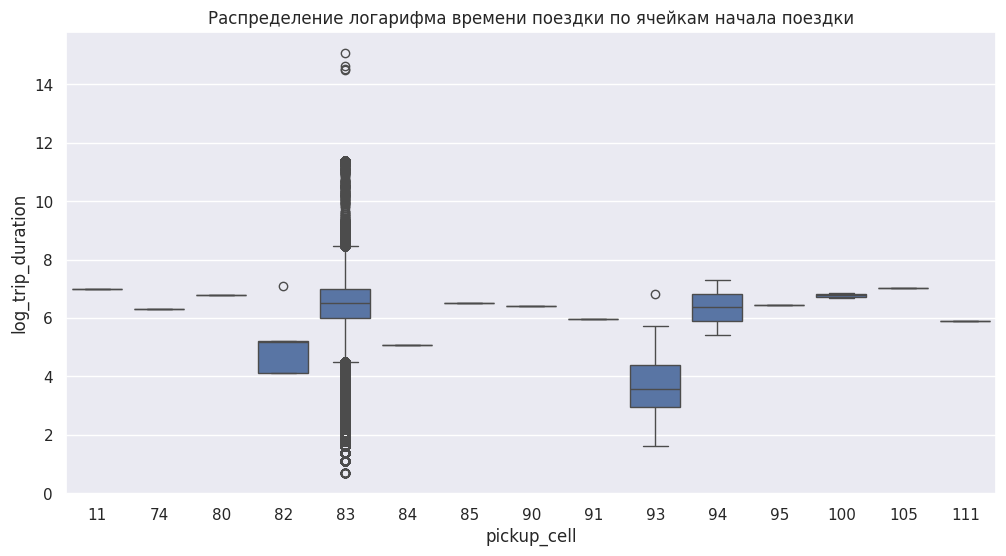

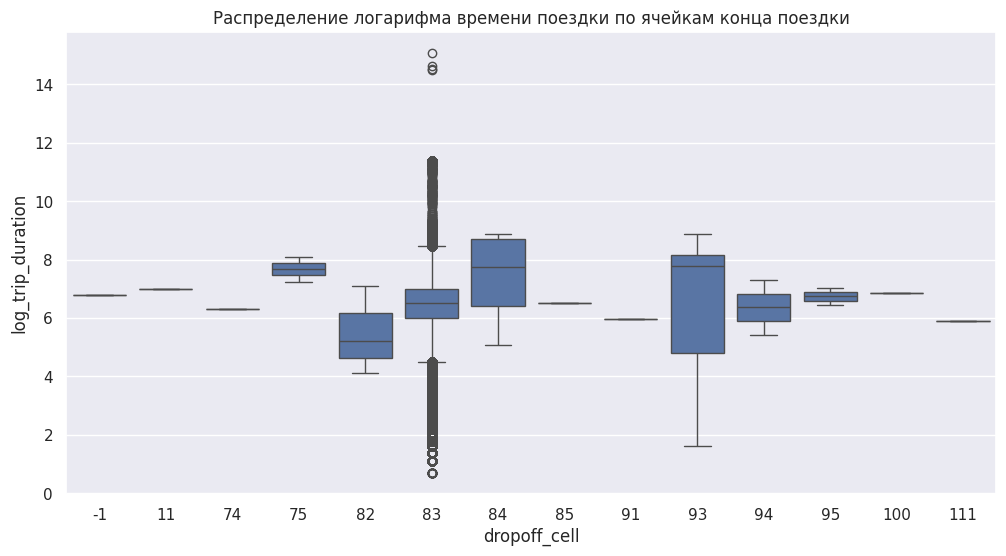

In [45]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=train_transformed, x='pickup_cell', y='log_trip_duration')
plt.title('Распределение логарифма времени поездки по ячейкам начала поездки')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(data=train_transformed, x='dropoff_cell', y='log_trip_duration')
plt.title('Распределение логарифма времени поездки по ячейкам конца поездки')
plt.show()

**Задание 10 (0.25 балла)**. Обучите `Ridge`-регрессию со стандартными параметрами на признаках, которые мы выделили к текущему моменту. Категориальные признаки закодируйте через one-hot-кодирование, числовые признаки отмасштабируйте.

In [46]:
train, test = train_test_split(train, test_size=0.3, random_state=10)

target_name = "log_trip_duration"
unnecessary_features = [target_name, "id", "vendor_id", "passenger_count", "pickup_datetime",
                        "pickup_longitude", "pickup_latitude", "dropoff_longitude",
                        "dropoff_latitude", "store_and_fwd_flag"]

categorical = ['weekday', 'month', 'rush_hour', 'free_from_traffic']
numeric_features = ['hour', 'day_number', 'log_haversine']

X_train, X_test = train.drop(columns=unnecessary_features), test.drop(columns=unnecessary_features)
y_train, y_test = train[target_name], test[target_name]

column_transformer = ColumnTransformer(
    [
        ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
        ('scaling', StandardScaler(), numeric_features)
    ]
)

pipeline = Pipeline(
    steps=[
        ('ohe_and_scaling', column_transformer),
        ('regression', Ridge())
    ]
)

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))


Test RMSE = 0.5211


## Часть 3. Изучаем оставшиеся признаки (1 балл)

**Задание 11 (0.75 баллов)**. У нас осталось еще 3 признака, которые мы не исследовали: `vendor_id`, `passenger_count` и `store_and_fwd_flag`.

**Вопрос**: Подумайте, почему каждый из этих признаков может быть потенциально полезным.

Посчитайте, сколько есть уникальных значений у каждого из этих признаков:

In [47]:
print("Уникальных значений vendor_id:", train['vendor_id'].nunique())
print("Уникальных значений passenger_count:", train['passenger_count'].nunique())
print("Уникальных значений store_and_fwd_flag:", train['store_and_fwd_flag'].nunique())


Уникальных значений vendor_id: 2
Уникальных значений passenger_count: 10
Уникальных значений store_and_fwd_flag: 2


Постройте "ящики с усами" распределений логарифма времени поездки в зависимости от значений каждого из признаков

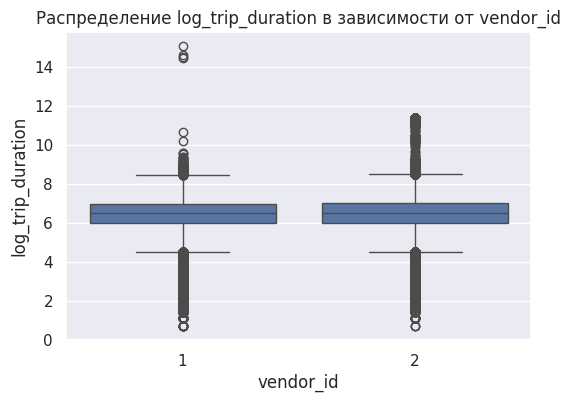

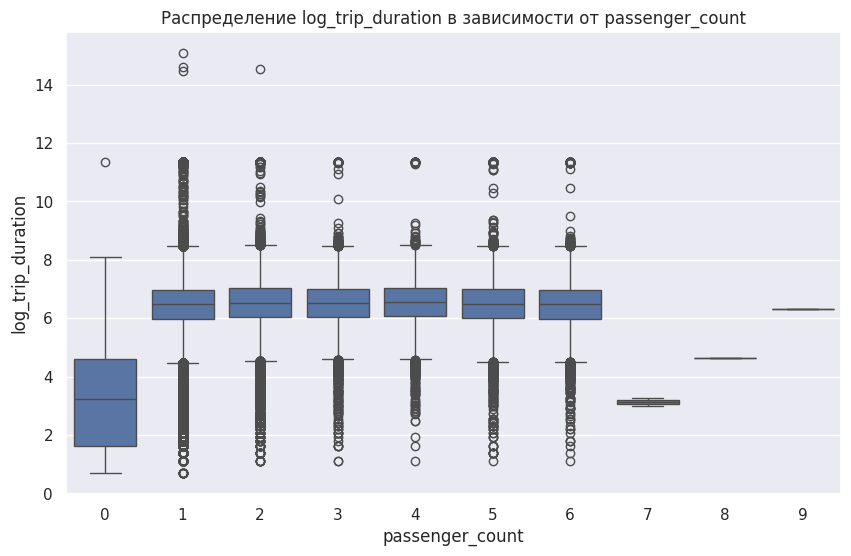

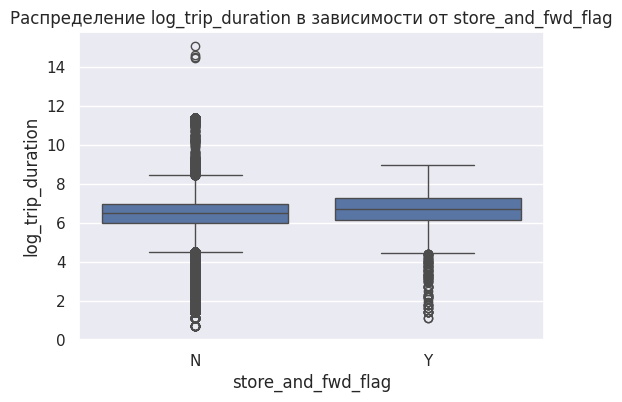

In [48]:
plt.figure(figsize=(6, 4))
sns.boxplot(x='vendor_id', y='log_trip_duration', data=train)
plt.title('Распределение log_trip_duration в зависимости от vendor_id')
plt.show()

plt.figure(figsize=(10, 6))
sns.boxplot(x='passenger_count', y='log_trip_duration', data=train)
plt.title('Распределение log_trip_duration в зависимости от passenger_count')
plt.show()

plt.figure(figsize=(6, 4))
sns.boxplot(x='store_and_fwd_flag', y='log_trip_duration', data=train)
plt.title('Распределение log_trip_duration в зависимости от store_and_fwd_flag')
plt.show()


Переведите признаки `vendor_id` и `store_and_fwd_flag` в значения $\{0;1\}$

In [49]:
train['vendor_id'] = train['vendor_id'].map({1: 0, 2: 1})

train['store_and_fwd_flag'] = train['store_and_fwd_flag'].map({'N': 0, 'Y': 1})

**Вопрос**: Основываясь на графиках выше, как вы думаете, будут ли эти признаки сильными?

**Задание 12 (0.25 баллов)**. Проверьте свои предположения, обучив модель в том числе и на этих трех признаках. Обучайте `Ridge`-регрессию со стандартными параметрами. Категориальные признаки закодируйте one-hot-кодированием, а численные отмасштабируйте.

In [50]:
unnecessary_features = [target_name, "id", "pickup_datetime",
                        'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
                        'dropoff_latitude']

categorical_features = ['weekday', 'month', 'vendor_id', "passenger_count", 'store_and_fwd_flag',
               'rush_hour', 'free_from_traffic']

numeric_features = ['hour', 'day_number', 'log_haversine']

X = train.drop(columns=unnecessary_features)
y = train[target_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

column_transformer = ColumnTransformer(
    [
        ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ('scaling', StandardScaler(), numeric_features)
    ]
)

pipeline = Pipeline(
    steps=[
        ('ohe_and_scaling', column_transformer),
        ('regression', Ridge())
    ]
)

model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))


Test RMSE = 0.5147


Если признаки не дали какого-то ощутимого улучшения метрики, их можно выбросить из данных.

## Часть 4. Улучшаем модель (3 балла)

**Задание 13 (1 балл)**. В наших данных есть нетипичные объекты (выбросы, или outliers): с аномально маленьким времени поездки, с очень большим пройденным расстоянием или очень большими остатками регрессии. В этом задании предлагается исключить такие объекты из обучающей выборки. Для этого нарисуйте гистограммы распределения упомянутых выше величин, выберите объекты, которые можно назвать выбросами, и очистите __обучающую выборку__ от них.

Отметим, что хотя эти объекты и выглядят как выбросы, в тестовой выборке тоже скорее всего будут объекты с такими же странными значениями целевой переменной и/или признаков. Поэтому, возможно, чистка обучающей выборки приведёт к ухудшению качества на тесте. Тем не менее, всё равно лучше удалять выбросы из обучения, чтобы модель получалась более разумной и интерпретируемой.

In [51]:


def haversine(lon1, lat1, lon2, lat2):
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371
    return c * r

train['haversine'] = train.apply(lambda x: haversine(x['pickup_longitude'], x['pickup_latitude'],
                                                     x['dropoff_longitude'], x['dropoff_latitude']), axis=1)


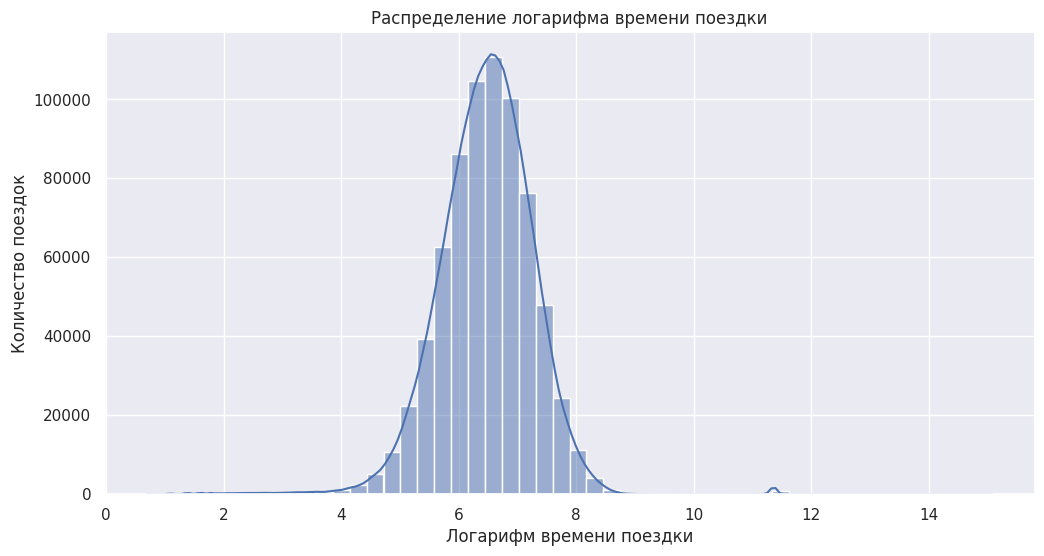

In [52]:

plt.figure(figsize=(12, 6))
sns.histplot(train['log_trip_duration'], bins=50, kde=True)
plt.title('Распределение логарифма времени поездки')
plt.xlabel('Логарифм времени поездки')
plt.ylabel('Количество поездок')
plt.show()


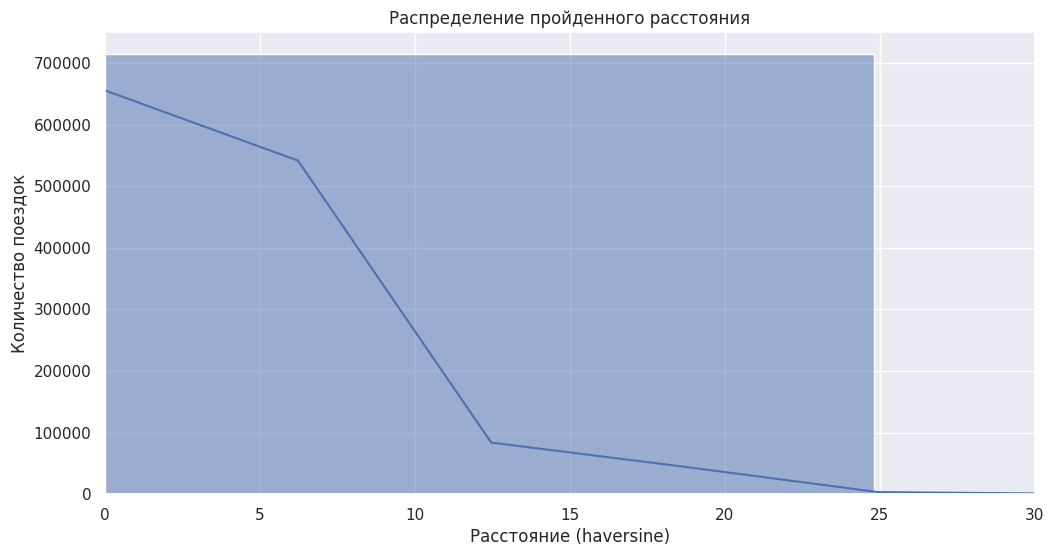

In [53]:
plt.figure(figsize=(12, 6))
sns.histplot(train['haversine'], bins=50, kde=True)
plt.title('Распределение пройденного расстояния')
plt.xlabel('Расстояние (haversine)')
plt.ylabel('Количество поездок')
plt.xlim(0, 30)
plt.show()

Сейчас у нас очень много категориальных признаков. В категориальных признаках могут содержаться редкие категории, обычно это плохо: модель сильно переобучается на таких примерах. Для каждого категориального признака объедините действительно редкие категории в одну, если такие имеются (т.е. если категории действительно редкие).

In [54]:
lower_bound, upper_bound = train['log_trip_duration'].quantile([0.005, 0.995])

train_filtered = train[(train['log_trip_duration'] > lower_bound) & (train['log_trip_duration'] < upper_bound)]


In [55]:
unnecessary_features = ["id", "pickup_datetime", "pickup_longitude", "pickup_latitude",
                        "dropoff_longitude", "dropoff_latitude", "store_and_fwd_flag"]

X = train_filtered.drop(columns=unnecessary_features + [target_name])
y = train_filtered[target_name]


In [56]:

categorical_features = ['weekday', 'month', "passenger_count",
               'rush_hour', 'free_from_traffic']

numeric_features = ['hour', 'day_number', 'log_haversine']


preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge())
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model_pipeline.fit(X_train, y_train)

y_pred = model_pipeline.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Test RMSE: {rmse}")


Test RMSE: 0.449664398879297


Обучите модель на очищенных данных и посчитайте качество на тестовой выборке.

**Задание 14 (1 балл)**. После OneHot-кодирования количество признаков в нашем датасете сильно возрастает. Посчитайте колиество признаков до и после кодирования категориальных признаков.

In [57]:
categorical_features = ["passenger_count", "weekday", "hour"]
numeric_features = ["log_haversine"]

initial_feature_count = len(categorical_features) + len(numeric_features)
print(f"Количество признаков до кодирования: {initial_feature_count}")

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numeric_features)
    ])

X_transformed = preprocessor.fit_transform(X_train)

encoded_feature_count = X_transformed.shape[1]
print(f"Количество признаков после кодирования: {encoded_feature_count}")


Количество признаков до кодирования: 4
Количество признаков после кодирования: 41


Попробуйте обучить не `Ridge`-, а `Lasso`-регрессию. Какой метод лучше?

In [58]:

model_pipeline_lasso = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Lasso(random_state=42))
])

model_pipeline_lasso.fit(X_train, y_train)

y_pred_lasso = model_pipeline_lasso.predict(X_test)
rmse_lasso = mean_squared_error(y_test, y_pred_lasso, squared=False)
print(f"Lasso RMSE: {rmse_lasso}")

print(f"Ridge RMSE: {rmse}")

Lasso RMSE: 0.7243798678455606
Ridge RMSE: 0.449664398879297


Разбейте _обучающую выборку_ на обучающую и валидационную в отношении 8:2. По валидационной выборке подберите оптимальные значения параметра регуляризации (по логарифмической сетке) для `Ridge` и `Lasso`, на тестовой выборке измерьте качество лучшей полученной модели.

In [59]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


In [60]:
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.25, random_state=42)

categorical_features = ['passenger_count', 'weekday', 'hour']
numeric_features = ['log_haversine']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

ridge_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', Ridge(random_state=42))])
lasso_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('regressor', Lasso(random_state=42, max_iter=10000))])

alpha_range = np.logspace(-4, 4, 50)

ridge_search = GridSearchCV(estimator=ridge_pipeline, param_grid={'regressor__alpha': alpha_range},
                            scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
lasso_search = GridSearchCV(estimator=lasso_pipeline, param_grid={'regressor__alpha': alpha_range},
                            scoring='neg_mean_squared_error', cv=5, n_jobs=-1)

ridge_search.fit(X_train, y_train)
lasso_search.fit(X_train, y_train)

best_ridge = ridge_search.best_estimator_
best_lasso = lasso_search.best_estimator_

y_pred_ridge = best_ridge.predict(X_test)
y_pred_lasso = best_lasso.predict(X_test)

rmse_ridge = mean_squared_error(y_test, y_pred_ridge, squared=False)
rmse_lasso = mean_squared_error(y_test, y_pred_lasso, squared=False)

print(f"Лучшее Ridge RMSE: {rmse_ridge}")
print(f"Лучшее Lasso RMSE: {rmse_lasso}")


Лучшее Ridge RMSE: 0.43062604214133376
Лучшее Lasso RMSE: 0.4306497131946537


Для каждого перебранного `alpha` для Lasso посчитайте количество нулевых весов в модели и нарисуйте график зависимости его от `alpha`. Как сильно придётся потерять в качестве, если мы хотим с помощью Lasso избавиться хотя бы от половины признаков?

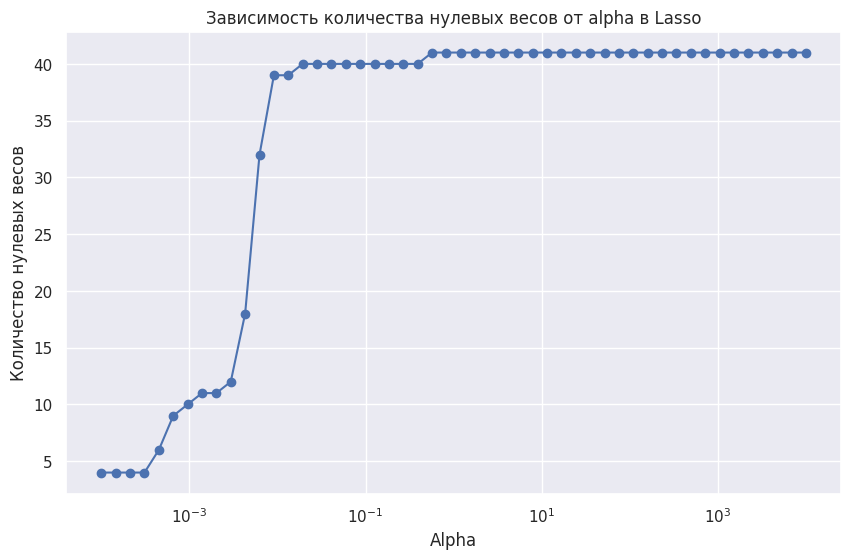

In [61]:
zeros = []

preprocessor.fit(X_train)

for alpha in alpha_range:
    lasso = Lasso(alpha=alpha, max_iter=10000, random_state=42)
    X_train_transformed = preprocessor.transform(X_train)
    lasso.fit(X_train_transformed, y_train)
    zeros.append(np.sum(lasso.coef_ == 0))

plt.figure(figsize=(10, 6))
plt.plot(alpha_range, zeros, marker='o')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Количество нулевых весов')
plt.title('Зависимость количества нулевых весов от alpha в Lasso')
plt.grid(True)
plt.show()


In [62]:
half_features_alpha = next(alpha for alpha, zero_count in zip(alpha_range, zeros) if zero_count >= initial_feature_count / 2)

lasso_half_features = Lasso(alpha=half_features_alpha, max_iter=10000, random_state=42).fit(preprocessor.transform(X_train), y_train)
y_pred_lasso_half_features = lasso_half_features.predict(preprocessor.transform(X_test))
rmse_lasso_half_features = mean_squared_error(y_test, y_pred_lasso_half_features, squared=False)

print(f"Lasso RMSE при исключении хотя бы половины признаков: {rmse_lasso_half_features}")
print(f"Лучшее Lasso RMSE: {rmse_lasso}")


Lasso RMSE при исключении хотя бы половины признаков: 0.4306497131946537
Лучшее Lasso RMSE: 0.4306497131946537


<img src="https://www.dropbox.com/s/wp4jj0599np17lh/map_direction.png?raw=1" width="20%" align="right" style="margin-left: 20px">

**Задание 15 (1 балл)**. Часто бывает полезным использовать взаимодействия признаков (feature interactions), то есть строить новые признаки на основе уже существующих. Выше мы разбили карту Манхэттена на ячейки и придумали признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка".

Давайте попробуем сделать следующее: посчитаем, сколько раз встречается каждая возможная пара этих признаков в нашем датасете и выберем 100 самых частых пар. Закодируем поездки с этими частыми парами как категориальный признак, остальным объектам припишем -1. Получается, что мы закодировали, откуда и куда должно было ехать такси.

Также можете придумать ещё какой-нибудь способ сделать признаки про маршрут. Если эти признаки будут давать хороший прирост в качестве, то за это могут быть даны дополнительные бонусные баллы.

**Вопрос**: Почему такой признак потенциально полезный? Почему линейная модель не может самостоятельно "вытащить" эту информацию, ведь у нее в распоряжении есть признаки "из какой ячейки началась поездка" и "в какой ячейке закончилась поездка"?

In [63]:
df['start_cell'] = pd.qcut(df['pickup_latitude'], 10, labels=False).astype(str) + "_" + pd.qcut(df['pickup_longitude'], 10, labels=False).astype(str)
df['end_cell'] = pd.qcut(df['dropoff_latitude'], 10, labels=False).astype(str) + "_" + pd.qcut(df['dropoff_longitude'], 10, labels=False).astype(str)

In [64]:
df['route'] = df['start_cell'].astype(str) + '_' + df['end_cell'].astype(str)

route_counts = df['route'].value_counts()
top_100_routes = route_counts.head(100).index.tolist()

df['frequent_route'] = df['route'].apply(lambda x: x if x in top_100_routes else -1)



df.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,log_trip_duration,...,month,weekday,hour,anomaly_1,anomaly_2,day_number,start_cell,end_cell,route,frequent_route
0,id2875421,2,2016-03-14 17:24:55,1,-73.982155,40.767937,-73.964630,40.765602,N,6.122493,...,3,0,17,0,0,74,7_4,6_7,7_4_6_7,-1
1,id2377394,1,2016-06-12 00:43:35,1,-73.980415,40.738564,-73.999481,40.731152,N,6.498282,...,6,6,0,0,0,164,2_5,2_1,2_5_2_1,-1
2,id3858529,2,2016-01-19 11:35:24,1,-73.979027,40.763939,-74.005333,40.710087,N,7.661527,...,1,1,11,0,0,19,6_5,0_0,6_5_0_0,-1
3,id3504673,2,2016-04-06 19:32:31,1,-74.010040,40.719971,-74.012268,40.706718,N,6.063785,...,4,2,19,0,0,97,0_0,0_0,0_0_0_0,0_0_0_0
4,id2181028,2,2016-03-26 13:30:55,1,-73.973053,40.793209,-73.972923,40.782520,N,6.077642,...,3,5,13,0,0,86,9_6,8_6,9_6_8_6,-1


Заново обучите модель (`Ridge`, если она дала более высокое качество в предыдущих экспериментах, и `Lasso` иначе) на новых даннных и посчитайте качество на тестовой выборке

In [66]:
df['log_haversine'] = np.log1p(df.apply(lambda row: haversine(row['pickup_longitude'], row['pickup_latitude'],
                                                              row['dropoff_longitude'], row['dropoff_latitude']), axis=1))


In [67]:
categorical_features = ['vendor_id', 'store_and_fwd_flag', 'weekday', 'month', 'anomaly_1', 'anomaly_2', 'frequent_route']
numeric_features = ['passenger_count', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'hour', 'day_number', 'log_haversine']

for col in categorical_features:
    df[col] = df[col].astype(str)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', Ridge(random_state=42))
])

X_train, X_test, y_train, y_test = train_test_split(df.drop(['log_trip_duration'], axis=1), df['log_trip_duration'], test_size=0.2, random_state=42)

model_pipeline.fit(X_train, y_train)

y_pred = model_pipeline.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f"RMSE на тестовой выборке: {rmse}")


RMSE на тестовой выборке: 0.5064871315021005


**Задание 16 (бонус, 1 балл)**. Где, как не для нашей задачи, считать манхэттенское расстояние?

**Вопрос**: Найдите, что такое манхэттенское расстояние и почему оно так называется. Как оно нам может помочь?

Введите систему координат на нашей карте так, чтобы оси были параллельны улицам Манхэттена, и добавьте сначала в данные признак "манхэттенское расстояние между пунктом отправления и пунктом назначения", а затем и логарифм этого признака. Посчитайте корреляцию между вашим новыми признаком и таргетом; между `log_haversine` и таргетом. В каком случае корреляция больше?

Нарисуйте карту, где покажете выбранные оси. Чтобы мы могли проверить вашу работу, просьба сделать скрин этой карты и приложить картинку (если мы откроем ваш ноутбук, виджеты отображаться не будут).

In [68]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Заново обучите модель на новых даннных и посчитайте качество на тестовой выборке. Стало ли лучше? Объясните полученный результат.

In [69]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

**Задание 17 (бонус, 2 балла)**. Реализуйте трансформер, который строит разбиение карты по шестигранной решётке с помощью библиотеки [H3](https://github.com/uber/h3-py) и вычисляет признаки на основе такого разбиения.

Признаки могут быть самые разные: расстояние между точкой старта и финиша, посчитанное в количестве шестиугольников; статистика по числу поездок и по их продолжительности в соседних шестиугольниках.

Важно: производительность библиотеки существенно зависит от количества шестиугольников на карте (определяется параметром resolution). Подберите такое разрешение, при котором ваш код будет работать за приемлемое время.

При построении признаков старайтесь не допустить утечки целевой переменной (подробнее про это можно почитать в материалах 1-го семинара) — в противном случае хорошего качества на тестовой выборке достичь не получится.

Измерьте качество после добавления новых признаков. За улучшение функционала ошибки на каждые 0.005 на тестовой выборке будет даваться 0.5 бонусных балла. Можно получить до 2 бонусных баллов за это задание.

In [70]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Вставьте картинку, описывающую ваш опыт выполнения этого ДЗ.